# Importing Libraries

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

In [3]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 1. Data cleaning 

In [5]:
import os

train_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\train" 
test_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\test" 
val_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\valid"

print(os.path.basename(train_dir),"class")
classes1 = os.listdir(train_dir)
for cls in classes1:
    print(f"Class: {cls}, Total images: {len(os.listdir(os.path.join(train_dir, cls)))}")
print("-"*50)
print(os.path.basename(test_dir),"class")
classes1 = os.listdir(test_dir)
for cls in classes1:
    print(f"Class: {cls}, Total images: {len(os.listdir(os.path.join(test_dir, cls)))}")
print("-"*50)
print(os.path.basename(val_dir),"class")
classes1 = os.listdir(val_dir)
for cls in classes1:
    print(f"Class: {cls}, Total images: {len(os.listdir(os.path.join(val_dir, cls)))}")

train class
Class: nowildfire, Total images: 14500
Class: wildfire, Total images: 15750
--------------------------------------------------
test class
Class: nowildfire, Total images: 2820
Class: wildfire, Total images: 3480
--------------------------------------------------
valid class
Class: nowildfire, Total images: 2820
Class: wildfire, Total images: 3480


In [6]:
from PIL import Image
import os

def remove_corrupted_images(directory):
    removed = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Check if image is corrupted
                except Exception as e:
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)
                    removed += 1
    print(f"Removed {removed} corrupted images from: {directory}")

# Run this for each folder
remove_corrupted_images(r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\train")
remove_corrupted_images(r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\test")
remove_corrupted_images(r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\valid")


Removed 0 corrupted images from: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\train
Removed 0 corrupted images from: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\test
Removed 0 corrupted images from: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\valid


# CNN Architecture

### 2. Data Preprocessing

In [9]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [10]:
train_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\train" 
test_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\test" 
valid_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\valid"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # For binary classification
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # order fixed for evaluation
)


Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [11]:
print("Class indices:", train_generator.class_indices)

Class indices: {'nowildfire': 0, 'wildfire': 1}


### 3. Modeling

In [13]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])


C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# compile the model

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [15]:
# Add checkpoint callback to save the best model
checkpoint = ModelCheckpoint("wildfire_cnn_best_model.h5", monitor='val_accuracy', 
                             save_best_only=True, mode='max')

# Train the model
history = cnn_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=3,
    callbacks=[checkpoint]
)

# Optional: Save the final model (not necessarily the best)
cnn_model.save("wildfire_cnn_final_model.h5")

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8357 - loss: 0.3278

946/946 ━━━━━━━━━━━━━━━━━━━━ 340s 357ms/step - accuracy: 0.8358 - loss: 0.3277 - val_accuracy: 0.9321 - val_loss: 0.1746
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 1097s 1s/step - accuracy: 0.9223 - loss: 0.2010 - val_accuracy: 0.8800 - val_loss: 0.4008
Epoch 3/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 336s 355ms/step - accuracy: 0.9377 - loss: 0.1669 - val_accuracy: 0.9316 - val_loss: 0.1868


### Model Evaluation

Accuracy plot saved to: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\CNN_report\accuracy_plot.png


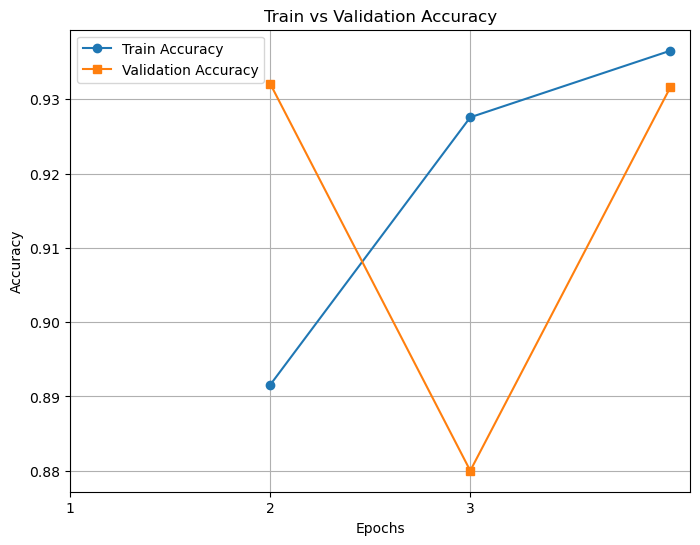

Loss plot saved to: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\CNN_report\loss_plot.png


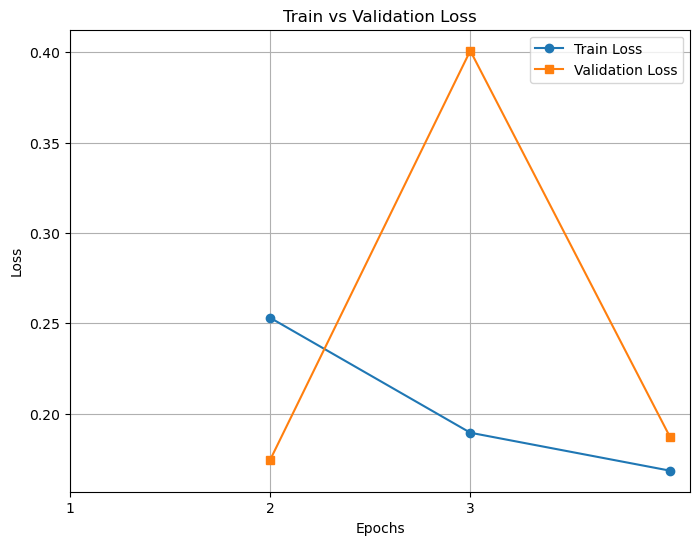

In [125]:
report_dir=r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\CNN_report"

# Training Performance 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([0,1,2],[1,2,3])
plt.legend()
plt.grid(True)
acc_plot_path = os.path.join(report_dir, 'accuracy_plot.png')
plt.savefig(acc_plot_path)
print(f"Accuracy plot saved to: {acc_plot_path}")
plt.show()

# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([0,1,2],[1,2,3])
plt.legend()
plt.grid(True)
loss_plot_path = os.path.join(report_dir, 'loss_plot.png')
plt.savefig(loss_plot_path)
print(f"Loss plot saved to: {loss_plot_path}")
plt.show()


#### Predictions on Test Set

In [18]:
# Get predictions
y_pred_prob = cnn_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# True labels
y_true = test_generator.classes


197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step


#### Classification Report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['nowildfire', 'wildfire']))


              precision    recall  f1-score   support

  nowildfire       0.94      0.92      0.93      2820
    wildfire       0.93      0.95      0.94      3480

    accuracy                           0.94      6300
   macro avg       0.94      0.93      0.93      6300
weighted avg       0.94      0.94      0.94      6300



#### Confusion Matrix

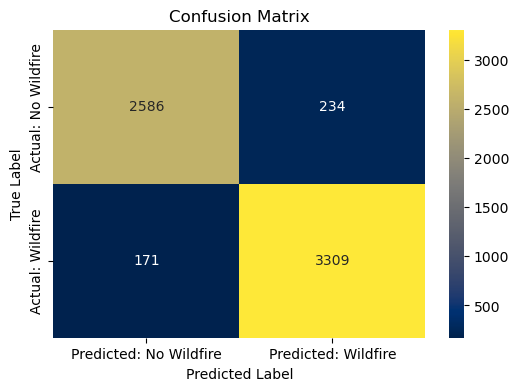

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis',
            xticklabels=['Predicted: No Wildfire', 'Predicted: Wildfire'],
            yticklabels=['Actual: No Wildfire', 'Actual: Wildfire'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
acc_plot_path = os.path.join(report_dir, 'confusion_matrix.png')
plt.savefig(acc_plot_path)
plt.show()

#### ROC Curve & AUC

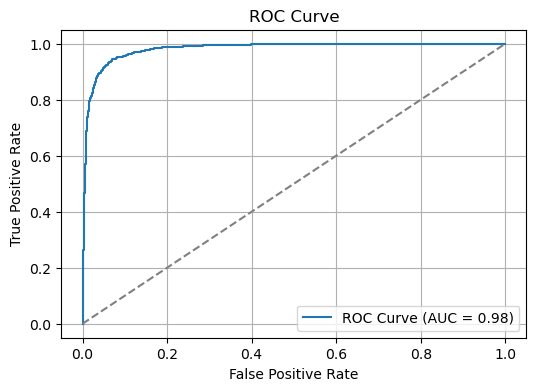

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
acc_plot_path = os.path.join(report_dir, 'ROC_AUC_Curve.png')
plt.savefig(acc_plot_path)
plt.show()

# ResNet50

### 2. Data Preprocessing

In [24]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_dir = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\train"
val_dir   = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\valid"
test_dir  = r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Data\test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Class indices: {'nowildfire': 0, 'wildfire': 1}


### 3. Modeling

In [27]:
# Load Pretrained ResNet50 Base

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_base.trainable = False  # Freeze base layers

In [28]:
# Custom Classifier Head

x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=output)

In [29]:
# compile the model

resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
# train the model

checkpoint = ModelCheckpoint("wildfire_resnet50_best_model.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max')

history1 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[checkpoint]
)

resnet_model.save("wildfire_resnet50_final_model.h5")

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.6690 - loss: 0.6366

946/946 ━━━━━━━━━━━━━━━━━━━━ 861s 905ms/step - accuracy: 0.6691 - loss: 0.6366 - val_accuracy: 0.8273 - val_loss: 0.4890
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8402 - loss: 0.4692

946/946 ━━━━━━━━━━━━━━━━━━━━ 804s 850ms/step - accuracy: 0.8402 - loss: 0.4692 - val_accuracy: 0.8513 - val_loss: 0.3973
Epoch 3/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 841s 889ms/step - accuracy: 0.8536 - loss: 0.4032 - val_accuracy: 0.8454 - val_loss: 0.3907


### Evaluation

Accuracy plot saved to: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\RESNET_report\accuracy_plot.png


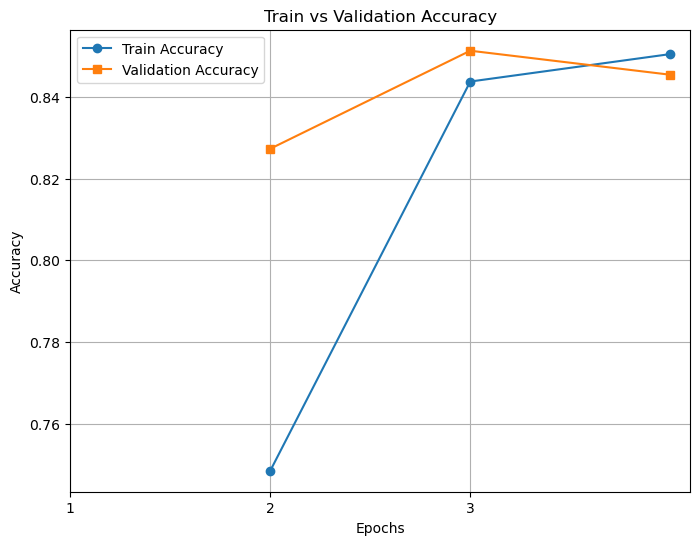

Loss plot saved to: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\RESNET_report\loss_plot.png


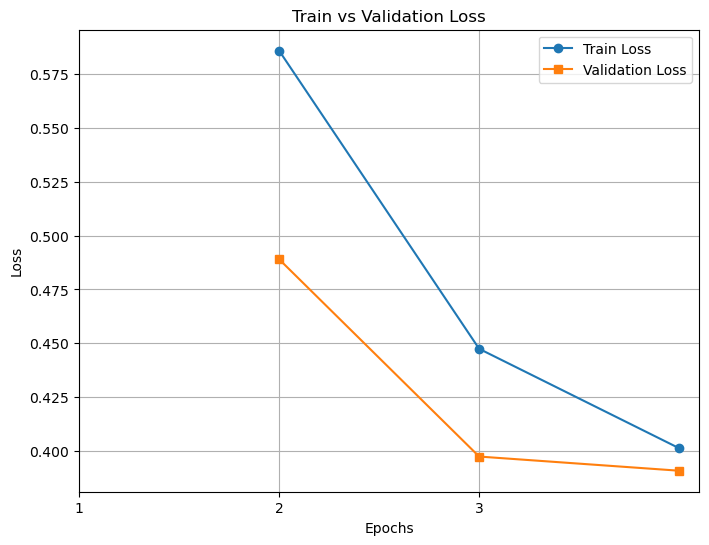

In [123]:
report_dir=r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\RESNET_report"

# Training Performance
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(1, len(acc)+1)

# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([0,1,2],[1,2,3])
plt.legend()
plt.grid(True)
acc_plot_path = os.path.join(report_dir, 'accuracy_plot.png')
plt.savefig(acc_plot_path)
print(f"Accuracy plot saved to: {acc_plot_path}")
plt.show()

# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([0,1,2],[1,2,3])
plt.legend()
plt.grid(True)
loss_plot_path = os.path.join(report_dir, 'loss_plot.png')
plt.savefig(loss_plot_path)
print(f"Loss plot saved to: {loss_plot_path}")
plt.show()

#### Predictions on Test Set

In [33]:
# Get predictions
y_pred_prob = resnet_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# True labels
y_true = test_generator.classes


197/197 ━━━━━━━━━━━━━━━━━━━━ 138s 692ms/step


#### Classification Report

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['nowildfire', 'wildfire']))


              precision    recall  f1-score   support

  nowildfire       0.83      0.87      0.85      2820
    wildfire       0.89      0.86      0.87      3480

    accuracy                           0.86      6300
   macro avg       0.86      0.86      0.86      6300
weighted avg       0.86      0.86      0.86      6300



#### Confusion Matrix

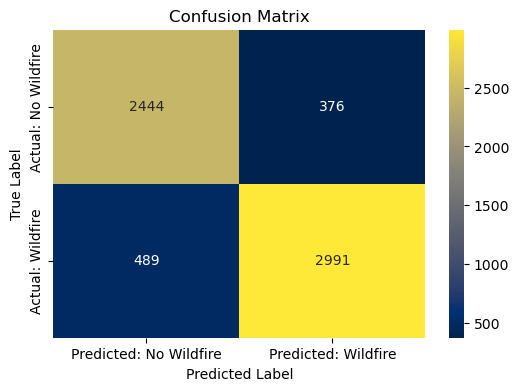

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis',
            xticklabels=['Predicted: No Wildfire', 'Predicted: Wildfire'],
            yticklabels=['Actual: No Wildfire', 'Actual: Wildfire'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
acc_plot_path = os.path.join(report_dir, 'confusion_matrix.png')
plt.savefig(acc_plot_path)
plt.show()

#### ROC Curve & AUC

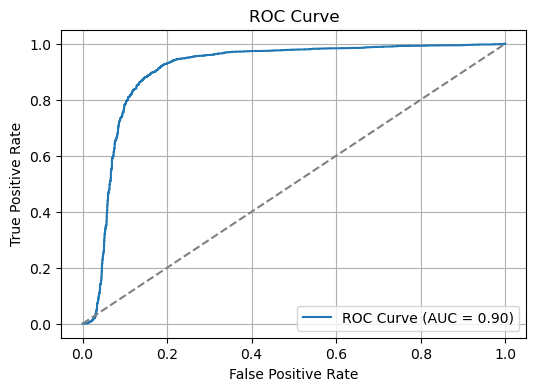

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
acc_plot_path = os.path.join(report_dir, 'ROC_AUC_Curve.png')
plt.savefig(acc_plot_path)
plt.show()

### 4. Results and Comparison

In [87]:
from tensorflow.keras.models import load_model

cnn_model = load_model("wildfire_cnn_final_model.h5")
resnet_model = load_model("wildfire_resnet50_final_model.h5")

In [89]:
y_true = test_generator.classes

# CNN predictions
y_pred_cnn_prob = cnn_model.predict(test_generator)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype("int32").flatten()

# ResNet50 predictions
y_pred_resnet_prob = resnet_model.predict(test_generator)
y_pred_resnet = (y_pred_resnet_prob > 0.5).astype("int32").flatten()


197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 133s 669ms/step


#### Classification Report

In [93]:
from sklearn.metrics import classification_report

print("CNN Classification Report")
print(classification_report(y_true, y_pred_cnn, target_names=['nowildfire', 'wildfire']))

print("\nResNet50 Classification Report")
print(classification_report(y_true, y_pred_resnet, target_names=['nowildfire', 'wildfire']))


CNN Classification Report
              precision    recall  f1-score   support

  nowildfire       0.94      0.92      0.93      2820
    wildfire       0.93      0.95      0.94      3480

    accuracy                           0.94      6300
   macro avg       0.94      0.93      0.93      6300
weighted avg       0.94      0.94      0.94      6300


ResNet50 Classification Report
              precision    recall  f1-score   support

  nowildfire       0.83      0.87      0.85      2820
    wildfire       0.89      0.86      0.87      3480

    accuracy                           0.86      6300
   macro avg       0.86      0.86      0.86      6300
weighted avg       0.86      0.86      0.86      6300



#### Confusion Matrix

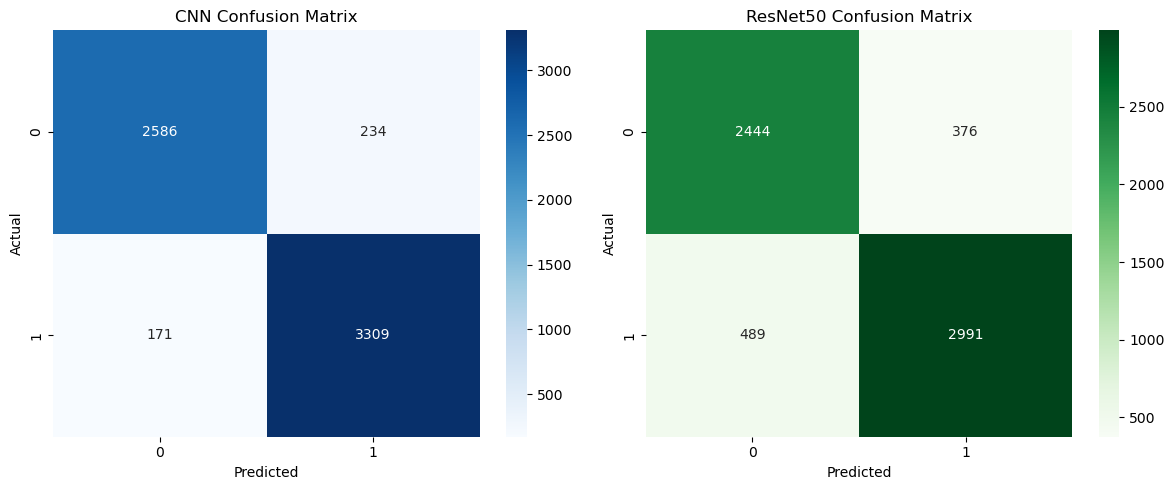

In [95]:
report_dir=r"C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Comparison_report"

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
cm_resnet = confusion_matrix(y_true, y_pred_resnet)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens')
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plot_path = os.path.join(report_dir, 'confusion_matrix.png')
plt.savefig(plot_path)
plt.show()


#### ROC curve Comparison

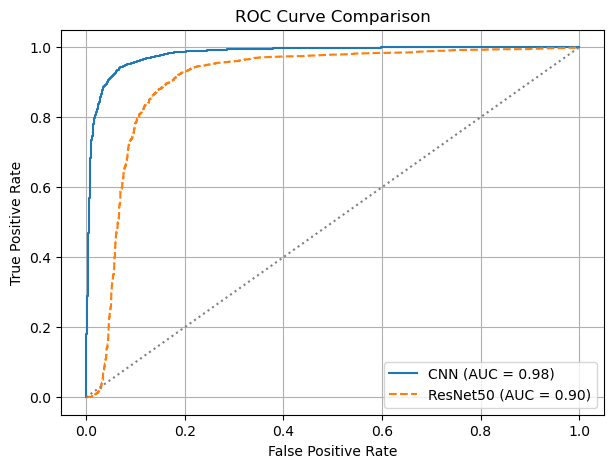

In [97]:
from sklearn.metrics import roc_curve, auc

fpr_cnn, tpr_cnn, _ = roc_curve(y_true, y_pred_cnn_prob)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true, y_pred_resnet_prob)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure(figsize=(7, 5))
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC = {auc_cnn:.2f})")
plt.plot(fpr_resnet, tpr_resnet, label=f"ResNet50 (AUC = {auc_resnet:.2f})", linestyle='--')
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plot_path = os.path.join(report_dir, 'ROC_AUC_Curve.png')
plt.savefig(plot_path)
plt.show()


#### Model Training Performance Comparison

Accuracy plot saved to: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\Comparison_report\accuracy_plot.png


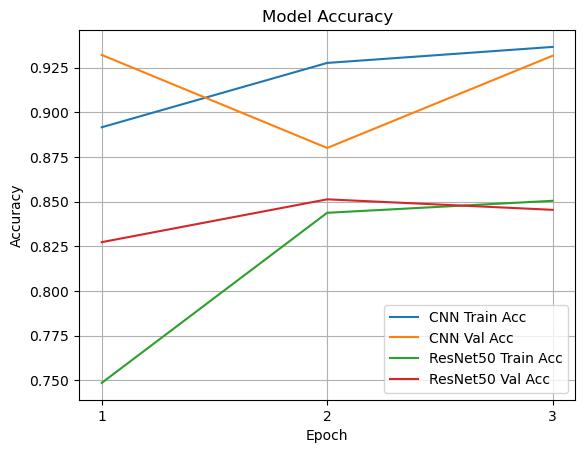

In [121]:
# CNN
plt.plot(history.history['accuracy'], label='CNN Train Acc')
plt.plot(history.history['val_accuracy'], label='CNN Val Acc')

# ResNet
plt.plot(history1.history['accuracy'], label='ResNet50 Train Acc')
plt.plot(history1.history['val_accuracy'], label='ResNet50 Val Acc')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([0,1,2],[1,2,3])
plt.legend()
plt.grid()
acc_plot_path = os.path.join(report_dir, 'accuracy_plot.png')
plt.savefig(acc_plot_path)
print(f"Accuracy plot saved to: {acc_plot_path}")
plt.show()


Loss plot saved to: C:\Users\lenovo\Documents\Projects\Wildlife_Prediction\CNN_report\loss_plot.png


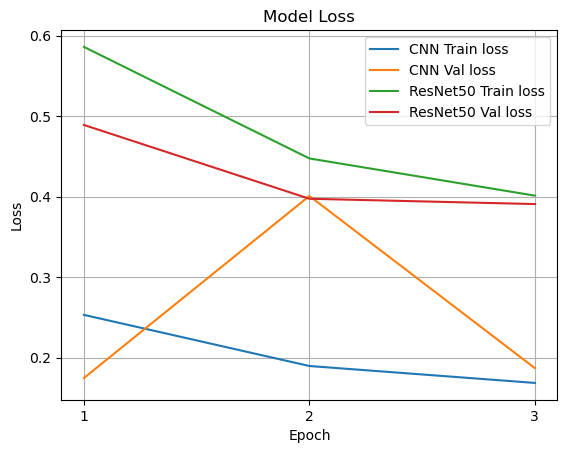

In [127]:
# CNN
plt.plot(history.history['loss'], label='CNN Train loss')
plt.plot(history.history['val_loss'], label='CNN Val loss')

# ResNet
plt.plot(history1.history['loss'], label='ResNet50 Train loss')
plt.plot(history1.history['val_loss'], label='ResNet50 Val loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0,1,2],[1,2,3])
plt.legend()
plt.grid()
plot_path = os.path.join(report_dir, 'loss_plot.png')
plt.savefig(plot_path)
print(f"Loss plot saved to: {plot_path}")
plt.show()


### Monitor time 
#### We can monitor the model trining process using below code.

In [132]:
import time

start_time = time.time()

# history = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=10,
#     callbacks=[checkpoint]
# )

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")



Training completed in 0.00 minutes
